### 0. Preparing Anomaly detection dataset
- train은 모두 정상 데이터(0)인 mnist로만 수행
- 이후 test 시 mnist+fashion_mnist 합친 test_concat을 사용하여 normal/anomal 판별하도록 함

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, classification_report, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, models
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

2025-06-25 15:33:14.659503: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-25 15:33:14.666313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750833194.674094  176726 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750833194.676678  176726 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750833194.683054  176726 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
(x_train_1, _), (x_test_1, _) = mnist.load_data() # normal(0) -> 얘만 학습에 이용
(x_train_2, _), (x_test_2, _) = fashion_mnist.load_data() # anomaly(1)

# 0-1 사이로 normalization
x_train_1 = x_train_1.astype('float32') / 255.
x_test_1 = x_test_1.astype('float32') / 255.
x_train_2 = x_train_2.astype('float32') / 255.
x_test_2 = x_test_2.astype('float32') / 255.

x_train_1 = x_train_1[..., tf.newaxis]  # (60000, 28, 28, 1)
x_test_1 = x_test_1[..., tf.newaxis]    # (10000, 28, 28, 1)
x_test_2 = x_test_2[..., tf.newaxis]    # (10000, 28, 28, 1)

test_concat = np.concatenate([x_test_1, x_test_2], axis=0)
# label 생성
y_true = np.concatenate([np.zeros(len(x_test_1)), np.ones(len(x_test_2))])

### Functions to use during the process

1. **Learning curve**를 통해 **적절한 epoch 수**를 찾을 수 있음
   - `loss` : train dataset의 reconstruction error (MSE)
   - `val_loss` : validation dataset(normal)의 reconstruction error
   - learning curve : epoch마다의 loss, val_loss graph
- epoch too low : underfitting | epoch too high : overfitting(overly optimized to the train dataset)
- **optimal point?** -> point where the `val_loss` gets minimize or doesn't decrease

In [3]:
def learning_curve(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

In [4]:
checkpoint1 = ModelCheckpoint(
    "best_model1.keras",     # 저장할 파일 이름
    save_best_only=True, # val_loss가 가장 낮을 때만 저장
    monitor="val_loss"   # 어떤 지표를 기준으로 최고 성능인지 판단(여기선 val_loss로 판단)
)

checkpoint2 = ModelCheckpoint("best_model2.keras", save_best_only=True, monitor="val_loss")

early_stop1 = EarlyStopping(
    monitor="val_loss",       # 어떤 지표를 기준으로 멈출지(여기선 val_loss를 기준으로 함)
    patience=5,              # 성능이 개선되지 않아도 추가로 더 기다릴 epoch 수
    mode="min",
    restore_best_weights=True  # 가장 성능이 좋았던 시점의 가중치를 자동 복원
)

early_stop2 = EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True)

2. 적절한 **threshold** 설정 - ROC curve를 통해 적절한 threshold 구하기
    - ROC Curve : 모델의 이진 분류 성능을 시각화하는 그래프
    - x축: FPR(False Positive Rate)
    - y축 : TPR(True Positive Rate = Recall)
    - threshold를 바꿔가며 FPR, TPR을 계산해 곡선을 그리며 ROC 곡선이 좌상단에 가까울수록 좋음 (TPR은 높을수록, FPR은 낮을수록 좋기 때문)
    - 즉 AUC(Area Under Curve)값이 1에 가까울수록 좋음

- `y_true` : 정상(0), 이상치(1)
- `y_score` : 오토인코더의 MSE값(클수록 이상치일 가능성 ↑)
- `y_pred` : 특정 threshold 기준으로 y_score > threshold 이면 이상치(1)

In [5]:
# MSE model
def make_model_mse(model: models.Model):
    assert isinstance(model, models.Model)
    input_s = model.inputs[0] 
    output_s = model.outputs[0] 

    # diff = layers.Subtract()([input_s, output_s]) # 얘도 가능
    diff = input_s - output_s
    squared = layers.Multiply()([diff, diff]) # K.square
    error_s = layers.Lambda(lambda x: tf.reduce_mean(x, axis=[1,2,3]))(squared) # K.mean (axis=1)
    
    return models.Model(inputs=input_s, outputs=error_s) # 하나의 스칼라 값을 담은 1D 벡터가 나와야 함

- 예시
y_true = [0, 0, 0, 1, 1, 1]  # 정상(0), 이상(1)
mse    = [0.01, 0.02, 0.03, 0.10, 0.15, 0.20]
- autoencoder에서 위와 같이 MSE 점수가 나오면 이제 다음과 같이 threshold를 바꿔가면서 아래처럼 예측값(y_pred)를 생성
  
| Threshold | y\_pred (mse > threshold) | TPR (Recall) | FPR   |
| --------- | ------------------------- | ------------ | ----- |
| 0.005     | 1,1,1,1,1,1               | 1.0          | 1.0   |
| 0.020     | 0,1,1,1,1,1               | 1.0          | 0.5   |
| 0.030     | 0,0,1,1,1,1               | 1.0          | 0.333 |
| 0.100     | 0,0,0,0,1,1               | 0.666        | 0.0   |
| 0.200     | 0,0,0,0,0,1               | 0.333        | 0.0   |
| 0.250     | 0,0,0,0,0,0               | 0.0          | 0.0   |

- 이렇게 다양한 threshold에 대해서 TPR, FPR을 계산해서 ROC 곡선을 자동으로 그리는 것

**roc_curve() 함수의 동작 방식**
1. `y_score`(mse)을 내림차순 정렬
2. 각 고유 점수 값들을 threshold로 설정해서 그 threshold보다 높은 점수를 가진 샘플들을 이상치(1)로 예측
3. 각 threshold마다 TPR(실제 이상치 중 맞춘 비율), FPR(실제 정상 중 틀린 비율)을 계산하여 반환
4. `thresholds`는 자동으로 생성되어 각 threshold가 기준일 때의 TPR과 FPR 쌍이 나오는 것!

In [6]:
# ROC Curve
def roc_curve_plot(fpr, tpr, roc_auc):
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0,1], [0,1], 'k--', label='0.5')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title('ROC Curve for Anomaly Detection')
    plt.legend()
    plt.grid(True)
    plt.show()

3. A function for **evaluating** each model
- calculating MSE
- measure ROC score and plot ROC curve

In [7]:
def evaluate_model(model, y_true, test_concat):
    assert isinstance(model, models.Model)
    model_mse = make_model_mse(model)
    y_score = model_mse.predict(test_concat) 

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Draw ROC curve
    roc_curve_plot(fpr, tpr, roc_auc)

    # 최적 threshold를 기준으로 이상치 판별
    # y_pred = (mse > optimal_threshold).astype(int)
    
    j_scores = tpr - fpr  # Youden's J = TPR - FPR
    best_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[best_idx]
    
    print(f"Best threshold : {optimal_threshold:.6f} | TPR : {tpr[best_idx]:.4f} | FPR : {fpr[best_idx]:.4f}\n")
    
    y_pred = (y_score > optimal_threshold).astype(int)
    print(classification_report(y_true, y_pred, target_names=["Normal", "Anomaly"]))
    print(f'ROC AUC score : {roc_auc:.6f}\n')

    return roc_auc, optimal_threshold, y_pred

In [8]:
# Input
input_img = layers.Input(shape=(28, 28, 1), name="input")

### 1. Conv2D-based Autoencoder ver.

In [9]:
def conv2d_autoencoder(input_img, latent_dim=32) -> models.Model:
    x1 = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2)(input_img)  # 14x14x32
    x1 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(x1)         # 7x7x64
    x1 = layers.Conv2D(latent_dim, (1,1), activation='relu', padding='same')(x1)           # 7x7xlatent_dim
    
    x1 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2)(x1) # 14x14x64
    x1 = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2)(x1) # 28x28x32
    x1 = decoded_cnn = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x1)          # 28x28x1
    
    
    # 3. Modeling
    model1 = Model(inputs=input_img, outputs=x1, name="conv2d_autoencoder")
    model1.compile(optimizer='adam', loss='mse')
    return model1

In [10]:
model1 = conv2d_autoencoder(input_img)
history1 = model1.fit(x_train_1, x_train_1, epochs=100, batch_size=256, callbacks=[checkpoint1, early_stop1], shuffle=True, validation_data=(x_test_1, x_test_1))

I0000 00:00:1750833196.241914  176726 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8968 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:02:00.0, compute capability: 8.9


Epoch 1/100


I0000 00:00:1750833197.346929  176850 service.cc:152] XLA service 0x7dfcc801dc50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750833197.346944  176850 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-06-25 15:33:17.362741: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1750833197.465222  176850 cuda_dnn.cc:529] Loaded cuDNN version 90701


 45/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1863

I0000 00:00:1750833198.617012  176850 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0804 - val_loss: 0.0027
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9691e-04 - val_loss: 8.8037e-04
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7940e-04 - val_loss: 7.9108e-04
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8269e-04 - val_loss: 7.0791e-04
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0739e-04 - val_loss: 6.4788e-04
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5380e-04 - val_loss: 5.9890e-04
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.0298e-04 - val_loss: 5.8287e-04
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6077e-04 - val_loss: 5.4003e

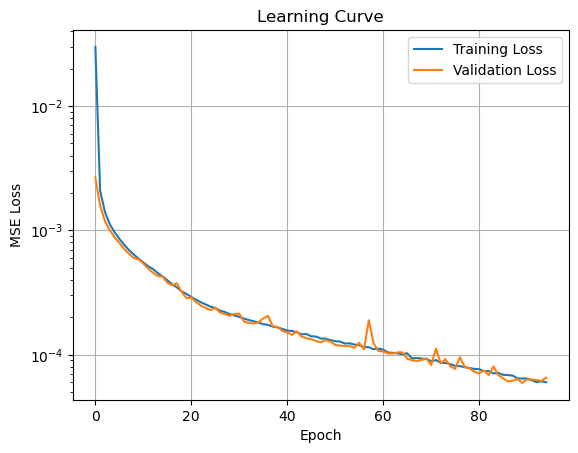

optimal epoch: 90


In [11]:
learning_curve(history1)
best_epoch1 = np.argmin(history1.history['val_loss']) + 1
print(f'optimal epoch: {best_epoch1}')

### 2. Ensemble(FC+Conv) Autoencoder ver.

In [12]:
def ensemble_autoencoder(input_img, latent_dim=32) -> models.Model:
    # 1-1. FCN Autoencoder (Flatten + Dense)
    x1 = layers.Flatten()(input_img)                # (None, 784)
    x1 = layers.Dense(128, activation='relu')(x1)
    x1 = layers.Dense(64, activation='relu')(x1)
    x1 = layers.Dense(latent_dim, activation='relu')(x1)
    
    x1 = layers.Dense(64, activation='relu')(x1)
    x1 = layers.Dense(128, activation='relu')(x1)
    x1 = layers.Dense(784, activation='sigmoid')(x1)
    decoded_fc = layers.Reshape((28, 28, 1))(x1)  # shape (28x28x1)
    
    # 1-2. CNN Autoencoder
    x2 = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=2)(input_img)  # 14x14x32
    x2 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(x2)         # 7x7x64
    x2 = layers.Conv2D(latent_dim, (1,1), activation='relu', padding='same')(x2)           # 7x7xlatent_dim
    
    x2 = layers.Conv2DTranspose(64, (3,3), activation='relu', padding='same', strides=2)(x2) # 14x14x64
    x2 = layers.Conv2DTranspose(32, (3,3), activation='relu', padding='same', strides=2)(x2) # 28x28x32
    x2 = decoded_cnn = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x2)          # 28x28x1
    
    # 2. Merge
    merged_output = decoded_fc + decoded_cnn  # shape: 28x28x1
    
    # 3. Modeling
    model2 = Model(inputs=input_img, outputs=merged_output, name="ensemble_autoencoder")
    model2.compile(optimizer='adam', loss='mse')
    return model2

In [13]:
# 4. generate ensemble autoencoder & train
model2 = ensemble_autoencoder(input_img)
history2 = model2.fit(x_train_1, x_train_1, epochs=100, batch_size=256, callbacks=[checkpoint2, early_stop2], shuffle=True, validation_data=(x_test_1, x_test_1))

Epoch 1/100


2025-06-25 15:35:00.851809: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_611', 8 bytes spill stores, 8 bytes spill loads

2025-06-25 15:35:00.949794: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_611', 12 bytes spill stores, 12 bytes spill loads

2025-06-25 15:35:01.067143: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_625', 4 bytes spill stores, 4 bytes spill loads

2025-06-25 15:35:01.246551: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_639', 8 bytes spill stores, 8 bytes spill loads

2025-06-25 15:35:01.273732: I external/local_xla/x

224/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2702

2025-06-25 15:35:06.362675: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_611', 164 bytes spill stores, 168 bytes spill loads

2025-06-25 15:35:06.446204: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_639', 8 bytes spill stores, 8 bytes spill loads

2025-06-25 15:35:06.737226: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_611', 12 bytes spill stores, 12 bytes spill loads

2025-06-25 15:35:07.065199: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_611', 132 bytes spill stores, 132 bytes spill loads

2025-06-25 15:35:07.113362: I external/loc

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2645

2025-06-25 15:35:10.860861: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_114', 8 bytes spill stores, 8 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.2640 - val_loss: 0.1064
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1038 - val_loss: 0.1010
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0964 - val_loss: 0.0540
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0388 - val_loss: 0.0263
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0254 - val_loss: 0.0220
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0218 - val_loss: 0.0195
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0196 - val_loss: 0.0179
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180 - val_loss: 0.0166
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168 - val_loss: 0.0157
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0158 - val_loss: 0.0148
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - val_loss: 0.0142
Epoch 12/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/st

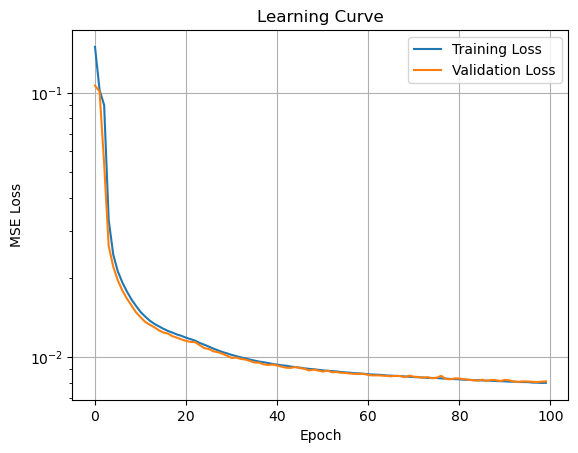

optimal epoch: 98


In [14]:
learning_curve(history2)
best_epoch2 = np.argmin(history2.history['val_loss']) + 1
print(f'optimal epoch: {best_epoch2}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step


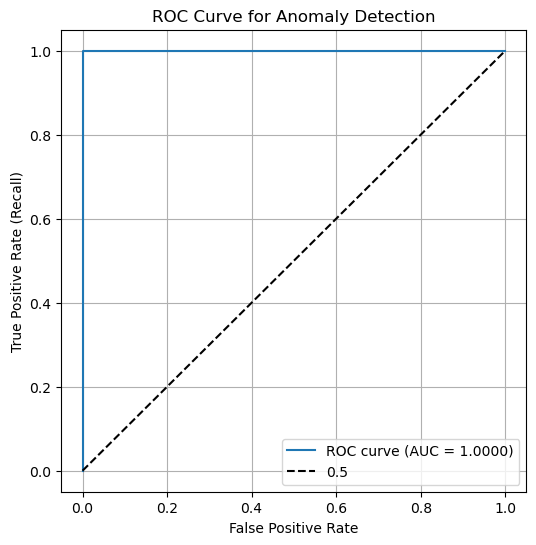

Best threshold : 0.000246 | TPR : 0.9999 | FPR : 0.0013

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     10000
     Anomaly       1.00      1.00      1.00     10000

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000

ROC AUC score : 0.999979



2025-06-25 15:37:03.902297: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 4 bytes spill stores, 4 bytes spill loads

2025-06-25 15:37:04.085964: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_87', 12 bytes spill stores, 12 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 827us/step


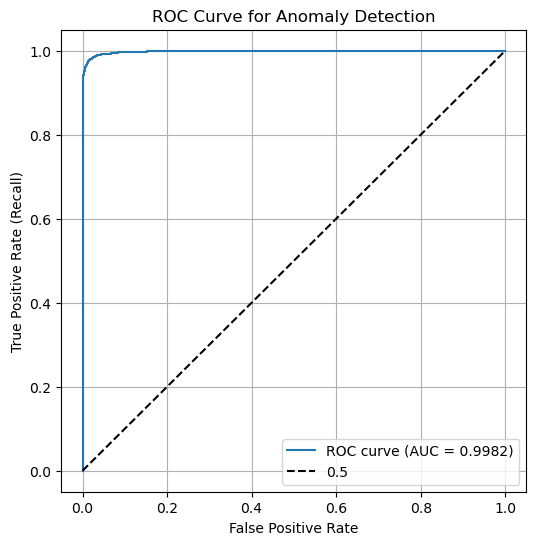

Best threshold : 0.022589 | TPR : 0.9785 | FPR : 0.0167

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     10000
     Anomaly       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000

ROC AUC score : 0.998183



In [15]:
auc1, th1, y_pred1 = evaluate_model(model1, y_true, test_concat)
auc2, th2, y_pred2 = evaluate_model(model2, y_true, test_concat)

### Model Comparison
- The ensemble model seem to perform a bit better than the Conv2D model!

In [16]:
results = pd.DataFrame({
    'Model': ['Conv2D', 'Ensemble'],
    'ROC AUC score': [auc1, auc2],
    'Best Threshold': [th1, th2],
    'F1-Score': [f1_score(y_true, y_pred1, average='macro'), f1_score(y_true, y_pred2, average='macro')]
})
print("\n======Model Comparison======")
print(results)


======Model Comparison======
      Model  ROC AUC score  Best Threshold  F1-Score
0    Conv2D       0.999979        0.000246   0.99925
1  Ensemble       0.998183        0.022589   0.98085


### 3. Measure the change in AUC score according to the d^h
- d^h : the dimension of the latent space bottleneck in the autoencoder model
- Using the ensemble model (which performed better in the previous process.)
- Experiment Purpose : control the dim(h) → train the model for each dimensions → detect anomalies → measure the AUC score → visualize (d^h vs AUC curve)

In [17]:
latent_dims = [2, 4, 8, 16, 32, 64, 128]
auc_scores = {}

for h in latent_dims:
    model = ensemble_autoencoder(input_img, latent_dim=h)
    model.fit(x_train_1, x_train_1, epochs=best_epoch2, batch_size=256, callbacks=[checkpoint2, early_stop2], shuffle=True, validation_data=(x_test_1, x_test_1))

    model_mse = make_model_mse(model)
    y_score = model_mse.predict(test_concat) # mse
    auc = roc_auc_score(y_true, y_score)
    auc_scores[h] = auc

print("\n === Latent Dimension vs AUC ===")
for h, auc in auc_scores.items():
    print(f"latent_dim={h}: AUC Score={auc:.4f}")

Epoch 1/98


2025-06-25 15:37:07.269003: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_618', 4 bytes spill stores, 4 bytes spill loads

2025-06-25 15:37:07.399620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_946', 48 bytes spill stores, 48 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.2561 - val_loss: 0.0120
Epoch 2/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - val_loss: 0.0065
Epoch 3/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 4/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 5/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 6/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0051 - val_loss: 0.0046
Epoch 7/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 9/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 10/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 11/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 12/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

2025-06-25 15:38:40.712481: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_946', 92 bytes spill stores, 92 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.2490 - val_loss: 0.0873
Epoch 2/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0801 - val_loss: 0.0544
Epoch 3/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0515 - val_loss: 0.0460
Epoch 4/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0451 - val_loss: 0.0429
Epoch 5/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0428 - val_loss: 0.0415
Epoch 6/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0415 - val_loss: 0.0408
Epoch 7/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0407 - val_loss: 0.0401
Epoch 8/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0401 - val_loss: 0.0397
Epoch 9/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0395 - val_loss: 0.0391
Epoch 10/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0389 - val_loss: 0.0383
Epoch 11/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0374 - val_loss: 0.0354
Epoch 12/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

2025-06-25 15:40:04.414638: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_946', 92 bytes spill stores, 92 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.2568 - val_loss: 0.1048
Epoch 2/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1005 - val_loss: 0.0917
Epoch 3/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0832 - val_loss: 0.0408
Epoch 4/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0385 - val_loss: 0.0335
Epoch 5/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0329 - val_loss: 0.0310
Epoch 6/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0310 - val_loss: 0.0296
Epoch 7/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0296 - val_loss: 0.0287
Epoch 8/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0288 - val_loss: 0.0280
Epoch 9/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0281 - val_loss: 0.0275
Epoch 10/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0277 - val_loss: 0.0272
Epoch 11/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0272 - val_loss: 0.0268
Epoch 12/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0

2025-06-25 15:41:33.392102: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_946', 88 bytes spill stores, 88 bytes spill loads



224/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2462

2025-06-25 15:41:37.165177: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_625', 8 bytes spill stores, 8 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.2400 - val_loss: 0.0709
Epoch 2/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0627 - val_loss: 0.0372
Epoch 3/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0346 - val_loss: 0.0290
Epoch 4/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0283 - val_loss: 0.0256
Epoch 5/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0255 - val_loss: 0.0234
Epoch 6/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0234 - val_loss: 0.0221
Epoch 7/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0223 - val_loss: 0.0213
Epoch 8/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0214 - val_loss: 0.0204
Epoch 9/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0206 - val_loss: 0.0198
Epoch 10/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0199 - val_loss: 0.0188
Epoch 11/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0189 - val_loss: 0.0180
Epoch 12/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

2025-06-25 15:45:27.183146: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_944', 280 bytes spill stores, 280 bytes spill loads

2025-06-25 15:45:27.462044: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_944', 92 bytes spill stores, 92 bytes spill loads



223/235 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2589

2025-06-25 15:45:30.499891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_944', 4 bytes spill stores, 4 bytes spill loads

2025-06-25 15:45:30.644659: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_944', 124 bytes spill stores, 124 bytes spill loads

2025-06-25 15:45:30.673358: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_944', 124 bytes spill stores, 124 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2532

2025-06-25 15:45:32.599620: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_100', 8 bytes spill stores, 8 bytes spill loads



235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.2528 - val_loss: 0.1122
Epoch 2/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1096 - val_loss: 0.1112
Epoch 3/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1090 - val_loss: 0.1099
Epoch 4/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1077 - val_loss: 0.1058
Epoch 5/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0767 - val_loss: 0.0273
Epoch 6/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0256 - val_loss: 0.0206
Epoch 7/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0203 - val_loss: 0.0177
Epoch 8/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0175 - val_loss: 0.0157
Epoch 9/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0158 - val_loss: 0.0143
Epoch 10/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.0133
Epoch 11/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0134 - val_loss: 0.0126
Epoch 12/98
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0

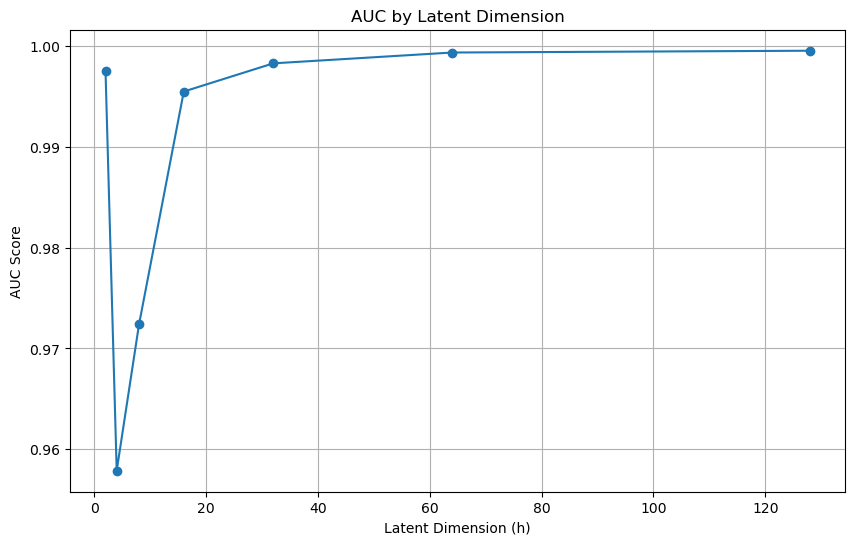

In [18]:
# Visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(list(auc_scores.keys()), list(auc_scores.values()), 'o-')
plt.xlabel('Latent Dimension (h)')
plt.ylabel('AUC Score')
plt.title('AUC by Latent Dimension')
plt.grid(True)
plt.show()